In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

data_dir = "hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

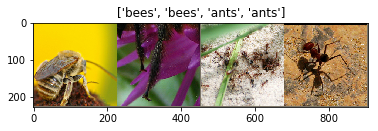

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
                    

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler= lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/yangpei/.torch/models/resnet18-5c106cde.pth
100.0%


In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 0/24
----------
train Loss: 0.4806 Acc: 0.7582
val Loss: 0.2732 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.5079 Acc: 0.7951
val Loss: 0.2959 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.4965 Acc: 0.7705
val Loss: 0.2645 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.4582 Acc: 0.8074
val Loss: 0.3059 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.5324 Acc: 0.7910
val Loss: 0.4384 Acc: 0.8105

Epoch 5/24
----------
train Loss: 0.5795 Acc: 0.8238
val Loss: 0.4133 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.4508 Acc: 0.8402
val Loss: 0.2651 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3386 Acc: 0.8852
val Loss: 0.2654 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3877 Acc: 0.8361
val Loss: 0.2364 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3263 Acc: 0.8566
val Loss: 0.2275 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2131 Acc: 0.9057
val Loss: 0.2613 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.3983 Acc: 0.8156
val Loss: 0.2201 Acc: 0.9346

Ep

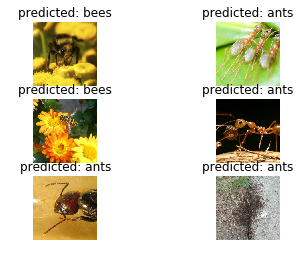

In [16]:
visualize_model(model_ft)

In [17]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [18]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler)

Epoch 0/24
----------
train Loss: 0.6094 Acc: 0.6557
val Loss: 0.2744 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.5706 Acc: 0.7869
val Loss: 0.6262 Acc: 0.7059

Epoch 2/24
----------
train Loss: 0.4484 Acc: 0.7869
val Loss: 0.1860 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.4242 Acc: 0.8197
val Loss: 0.2568 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.3762 Acc: 0.8238
val Loss: 0.2138 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.5223 Acc: 0.8033
val Loss: 0.2854 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.3970 Acc: 0.8238
val Loss: 0.7065 Acc: 0.7778

Epoch 7/24
----------
train Loss: 0.4882 Acc: 0.8197
val Loss: 0.1767 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3445 Acc: 0.8361
val Loss: 0.1957 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3322 Acc: 0.8648
val Loss: 0.1926 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2866 Acc: 0.8770
val Loss: 0.1828 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3476 Acc: 0.8566
val Loss: 0.1765 Acc: 0.9542

Ep

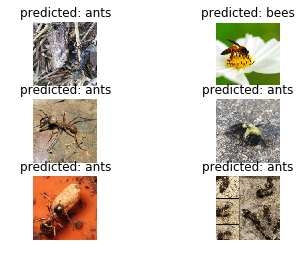

In [19]:
visualize_model(model_conv)